<a href="https://colab.research.google.com/github/SeraphDev6/BigMart-Sales-Predictions/blob/main/BigMart_Sales_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BigMart Sales Predictions by Wesley Giles

## Import necessary modules and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


df = pd.read_csv("https://docs.google.com/spreadsheets/d/17_svn8lKuMPh4sl01a8Fca656yLRwbkYD2osTgmrvi8/export?format=csv")
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Data Cleaning

### Understand the shape of the data

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### Deal with duplicated data (if any)

In [3]:
df.duplicated().sum()

0

### Look for missing data

In [4]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

#### Item weight seems to be miissing quite a few values, so lets try to intercate the values

##### Here we based the intercated values on the mean of the rest if the items that share a type with

In [5]:
avg_weights_by_type = df.groupby("Item_Type")["Item_Weight"].mean()
for item_type in df["Item_Type"].unique():
  df.loc[df["Item_Type"] == item_type,["Item_Weight"]] = \
  df.loc[df["Item_Type"] == item_type,["Item_Weight"]].fillna(avg_weights_by_type[item_type])
df.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

#### Lets see what values Outlet_Size has

In [6]:
df["Outlet_Size"].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

#### Attempting to crossmatch Outlet_Identifier to fill in Outlet Size

In [7]:
df.groupby("Outlet_Identifier")[["Outlet_Size","Outlet_Location_Type"]].count()

,Outlet_Size,Outlet_Location_Type
Outlet_Identifier,,
OUT010,0,555
OUT013,932,932
OUT017,0,926
OUT018,928,928
OUT019,528,528
OUT027,935,935
OUT035,930,930
OUT045,0,929
OUT046,930,930


#### No such luck so we will put "Unknown" as the size, as the remaining data may hold some insight

In [8]:
df["Outlet_Size"].fillna("Unknown", inplace=True)
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

#### "High also doesn't quite fit the them so we will change it to "Large"

In [9]:
df.loc[df["Outlet_Size"]=="High",["Outlet_Size"]] ="Large"
df["Outlet_Size"].unique()

array(['Medium', 'Unknown', 'Large', 'Small'], dtype=object)

### Look for inconsistant data


In [10]:
df.nunique()

Item_Identifier              1559
Item_Weight                   431
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

#### Item Fat Content looks a bit high so lets take a closer look

In [11]:
df["Item_Fat_Content"].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

#### Normalizing Item Fat Content

In [12]:
df["Item_Fat_Content"].replace(["low fat","LF"],"Low Fat", inplace=True)
df["Item_Fat_Content"].replace("reg","Regular", inplace=True)
df.nunique()

Item_Identifier              1559
Item_Weight                   431
Item_Fat_Content                2
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

#### Checking Item Type just to be sure

In [13]:
df["Item_Type"].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

### Finally checking numerical data for outliers

In [14]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857890,0.066132,140.992782,1997.831867,2181.288914
std,4.232804,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.867061,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


### There is a massive difference between Item_Outlet_Sales 75% mark and the max, likely indicating a lot of outliers. Lets check this out using a boxplot.

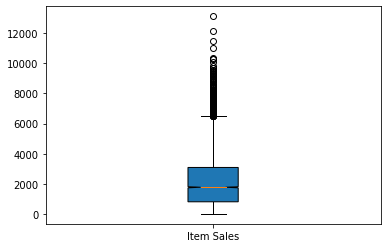

In [15]:
fig, ax = plt.subplots()
ax.boxplot([df["Item_Outlet_Sales"]],labels = ["Item Sales"],
           notch=True,
           patch_artist=True)
plt.show()

### Yea, this definitley looks odd, lets get a count of the number of outliers.

In [16]:
sales = df['Item_Outlet_Sales']
q1 = sales.quantile(0.25)
q3 = sales.quantile(0.75)
iqr = q3 - q1

outliers = df[sales > q3 + iqr * 1.5]
outliers

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
43,FDC02,21.350000,Low Fat,0.069103,Canned,259.9278,OUT018,2009,Medium,Tier 3,Supermarket Type2,6768.5228
130,FDY25,12.305705,Low Fat,0.033810,Canned,180.5976,OUT027,1985,Medium,Tier 3,Supermarket Type3,7968.2944
132,NCR53,13.142314,Low Fat,0.144338,Health and Hygiene,224.4404,OUT027,1985,Medium,Tier 3,Supermarket Type3,6976.2524
145,FDP16,18.600000,Low Fat,0.039356,Frozen Foods,246.3802,OUT049,1999,Medium,Tier 1,Supermarket Type1,7370.4060
203,FDI24,12.277108,Low Fat,0.078362,Baking Goods,177.9370,OUT027,1985,Medium,Tier 3,Supermarket Type3,6704.6060
...,...,...,...,...,...,...,...,...,...,...,...,...
8245,FDU55,16.200000,Low Fat,0.035967,Fruits and Vegetables,260.3278,OUT049,1999,Medium,Tier 1,Supermarket Type1,7549.5062
8329,NCQ06,13.384736,Low Fat,0.041622,Household,253.6014,OUT027,1985,Medium,Tier 3,Supermarket Type3,6630.0364
8350,NCE18,10.000000,Low Fat,0.021421,Household,248.3750,OUT035,2004,Small,Tier 2,Supermarket Type1,7240.5750
8447,FDS26,20.350000,Low Fat,0.089975,Dairy,261.6594,OUT017,2007,Unknown,Tier 2,Supermarket Type1,7588.1226


### 186 outliers. Lets drop this data for now

In [17]:
df.drop(outliers.index,axis=0 ,inplace=True)
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8337.000000,8337.000000,8337.000000,8337.000000,8337.000000
mean,12.856296,0.066358,139.161087,1997.968094,2059.362844
std,4.256788,0.051838,61.553351,8.309941,1506.099754
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.300000,0.027028,93.046200,1987.000000,810.944400
50%,12.867061,0.053939,141.215400,1999.000000,1747.059200
75%,16.100000,0.095299,183.695000,2004.000000,2998.097400
max,21.350000,0.328391,266.888400,2009.000000,6478.234000


## Exploratory Plots

### There are many factors which can contribute to the sales of an object, so lets start by looking into any corellation between numerical values

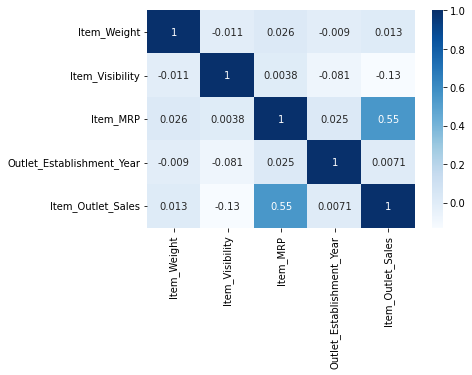

In [18]:
sns.heatmap(df.corr(),cmap="Blues",annot= True)

### This heatmap tells us there is a correlation between the Maximum Retail Price of an Item and the total revenue produced from sale of the item at an outlet, which makes logical sense, as a more expensive product provides more revenue per item sold.

### More importantly it tells us that item visibilty has a negative correlation with total revenue generated, meaning that this may be a way to predict future sales. We will explore this more with a scatter plot

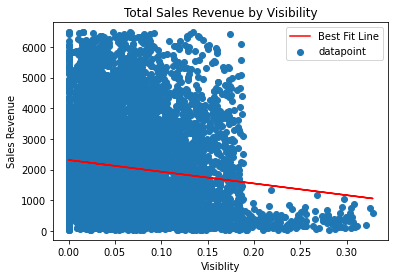

In [19]:
x = df['Item_Visibility']
y = df['Item_Outlet_Sales']

a,b = np.polyfit(x,y,1)

fig, ax = plt.subplots()

ax.scatter(x,y, label = "datapoint")
ax.plot(x,a*x+b, "r-", label="Best Fit Line")
ax.legend()
ax.set_title("Total Sales Revenue by Visibility")
ax.set_xlabel("Visiblity")
ax.set_ylabel("Sales Revenue")
plt.show()

### From the previous scatter plot we can see that there is a negative correlation between visibility and sales, with a large drop off at approximately 0.19 visibility

### Now lets look at some catgorical data. We will start with Outlet Size

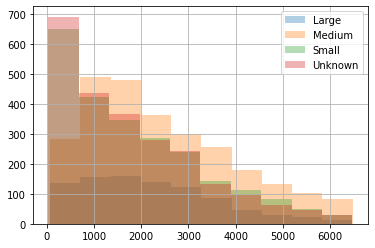

In [20]:
histogram = df.groupby("Outlet_Size")["Item_Outlet_Sales"].hist(alpha=0.35,legend=True)

### While most of the different sizes seem to fall into similar patterns, the Medium sized outlets seem to have a larger percentage of high sales items in comparison to the other sizes, We will visualize this in a different way using a boxplot

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


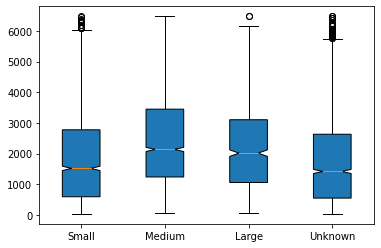

In [21]:
large = df[df["Outlet_Size"]=="Large"]["Item_Outlet_Sales"]
med = df[df["Outlet_Size"]=="Medium"]["Item_Outlet_Sales"]
small = df[df["Outlet_Size"]=="Small"]["Item_Outlet_Sales"]
uk = df[df["Outlet_Size"]=="Unknown"]["Item_Outlet_Sales"]


fig, ax = plt.subplots()
bps = ax.boxplot([small, med, large, uk],labels=["Small","Medium","Large","Unknown"], notch=True,
                 patch_artist=True)
plt.show()

In [22]:
df.groupby("Outlet_Size")["Item_Outlet_Sales"].describe()

,count,mean,std,min,25%,50%,75%,max
Outlet_Size,,,,,,,,
Large,917.0,2217.100205,1398.677744,73.2380,1057.95620,2014.7108,3103.95960,6474.2392
Medium,2676.0,2458.690424,1530.464302,69.2432,1238.22155,2135.8864,3448.84400,6478.2340
Small,2362.0,1852.606258,1483.026265,33.9558,593.22780,1517.3582,2775.55375,6474.2392
Unknown,2382.0,1755.044328,1432.707736,33.2900,549.28500,1417.4882,2631.24160,6471.5760


### Here we are confirming our assessment that Medium sized outlets have higher average sales per item, based on the higher mean, median, and range

## Explanatory diagrams

### In order for the Client to have a better idea of the data we are working with we will organize the Total sales based on a few criteria

#### First we will explore Sales Per Outlet, grouped by size

In [23]:
fig = px.histogram(df,x="Outlet_Identifier", y="Item_Outlet_Sales",
                   title="Total Sales Per Outlet",
                   hover_data=['Outlet_Size'],
                   color ="Outlet_Size",
                   labels = {"Outlet_Size": "Outlet Size",
                             "Outlet_Identifier": "Outlet ID",
                             "Item_Outlet_Sales": "Total Sales"},
                   category_orders = {"Outlet_Size":["Small",
                                                     "Medium",
                                                     "Large",
                                                     "Unknown"]})

fig.show()

#### Next we will explore Sales by Item Type, grouped by Outlet Type

In [24]:
fig = px.histogram(df,x="Item_Type", y="Item_Outlet_Sales",
                   title="Total Sales Per Item Type",
                   hover_data=['Outlet_Type'],
                   color ="Outlet_Type",
                   labels = {"Outlet_Type": "Outlet Type",
                             "Item_Type": "Item Type",
                             "Item_Outlet_Sales": "Total Sales"},
                   category_orders = {"Outlet_Type":["Supermarket Type1",
                                                     "Supermarket Type2",
                                                     "Supermarket Type3",
                                                     "Grocery Store"]},)

fig.show()

### With these interactive Graphs the Client can easily look for trends in the data and use them to make business decisions.

## Machine Learning

### With the power of Machine learning, meaningful data analysis can be done automatically, and predictions can be made relatively accurately by the computer

### Lets start by importing the modules we will need

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

### Now we will seperate the data into our prediction's target (Item_Outlet_Sales) and the data used to estimate that target. We will also seperate out test data from validation data to prevent data leaks.

In [26]:
y = df["Item_Outlet_Sales"]

numeric_features = ["Item_Weight",
                    "Item_Visibility",
                    "Item_MRP",
                    "Outlet_Establishment_Year"]
ordinal_encoded_features = ["Outlet_Size",
                            "Outlet_Type",
                            "Outlet_Identifier",
                            "Item_Type",
                            "Item_Fat_Content"]

# Include all fatures to be included in the model
X = df[numeric_features + ordinal_encoded_features]
X.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Type,Outlet_Identifier,Item_Type,Item_Fat_Content
0,9.30,0.016047,249.8092,1999,Medium,Supermarket Type1,OUT049,Dairy,Low Fat
1,5.92,0.019278,48.2692,2009,Medium,Supermarket Type2,OUT018,Soft Drinks,Regular
2,17.50,0.016760,141.6180,1999,Medium,Supermarket Type1,OUT049,Meat,Low Fat
3,19.20,0.000000,182.0950,1998,Unknown,Grocery Store,OUT010,Fruits and Vegetables,Regular
4,8.93,0.000000,53.8614,1987,Large,Supermarket Type1,OUT013,Household,Low Fat


### Lets split the data now to avoid any data leaks

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=1)

### Now lets convert the objects into numbers for the model to use

In [28]:
ord_enc = OrdinalEncoder()
X_train[ordinal_encoded_features] = ord_enc.fit_transform(X_train[ordinal_encoded_features],y_train)
X_valid[ordinal_encoded_features] = ord_enc.transform(X_valid[ordinal_encoded_features])
X_train.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Type,Outlet_Identifier,Item_Type,Item_Fat_Content
6613,8.630000,0.032961,115.0518,1999,1.0,1.0,9.0,13.0,1.0
3895,20.100000,0.000000,61.3536,1998,3.0,0.0,0.0,8.0,0.0
5894,12.817344,0.000000,98.2042,1985,2.0,0.0,4.0,10.0,1.0
5726,21.100000,0.000000,233.2958,2009,1.0,2.0,3.0,9.0,0.0
1771,13.500000,0.021496,180.5976,1997,2.0,1.0,8.0,6.0,0.0


### Lets make and train the model now

In [29]:
model = RandomForestRegressor(random_state=1) # random state is so that testing can be measured reliably

model.fit(X_train,y_train)

RandomForestRegressor(random_state=1)

### We need a way to test the effectiveness of the model

In [30]:
def get_MAE(model,X,y):
  return mean_absolute_error(model.predict(X),y)

def get_percent(model,X,y):
  return 1-(get_MAE(model,X,y)/y.mean())
def print_stats(model,X,y):
  print("The MAE for this model is {:.2f}".format(get_MAE(model,X,y)))
  print("The accuracy for this model is {:%}".format(get_percent(model,X,y)))

print_stats(model,X_valid,y_valid)

The MAE for this model is 744.32
The accuracy for this model is 63.953409%


### Well thats *slightly* better than flipping a coin... Lets try to improve this model a bit. We can start by defining the number of estimators.

In [31]:
results = {}
for i in range(1,7):
  test_model = RandomForestRegressor(n_estimators=i*50,random_state=1)
  test_model.fit(X_train,y_train)
  results[i*50] = get_MAE(test_model,X_valid,y_valid)
  print(f"{i*50}:")
  print_stats(test_model,X_valid,y_valid)

50:
The MAE for this model is 743.92
The accuracy for this model is 63.972851%
100:
The MAE for this model is 744.32
The accuracy for this model is 63.953409%
150:
The MAE for this model is 743.67
The accuracy for this model is 63.984932%
200:
The MAE for this model is 742.69
The accuracy for this model is 64.032610%
250:
The MAE for this model is 741.80
The accuracy for this model is 64.075361%
300:
The MAE for this model is 741.77
The accuracy for this model is 64.077056%


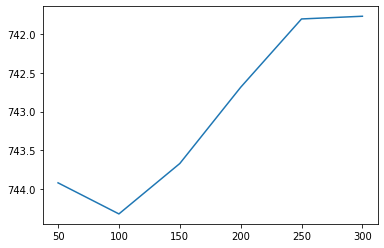

In [32]:
plt.plot([*results.keys()],[*results.values()] )
plt.gca().invert_yaxis()
plt.show()

### This isn't helping by much (less than 1% difference), so we should consider using a different algorithm, Lets try a Gradient Boosting Algorithm.

In [33]:
from xgboost.sklearn import XGBRegressor

In [34]:
model2 = XGBRegressor(n_estimators = 2000,
                     learning_rate=0.005,
                     early_stopping_rounds = 10,
                     random_state= 1)

model2.fit(X_train,y_train,
          eval_set= [(X_valid, y_valid)],
          verbose = False)

print_stats(model2,X_valid,y_valid)

[14:48:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The MAE for this model is 706.50
The accuracy for this model is 65.784921%


### There is some improvement, however still not enough to accurately predict sales, so lets create a deep nueral network.

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

In [36]:
model3 = keras.Sequential([
    layers.BatchNormalization(input_shape = [X_train.shape[1]]),
    layers.Dense(256,activation="relu"),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(256,activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1)
])
early_stopping = callbacks.EarlyStopping(
    min_delta = 0.001,
    patience = 20,
    restore_best_weights = True
)

Minimum Validation Loss: 699.5413
Highest Accuracy: 66.0312%


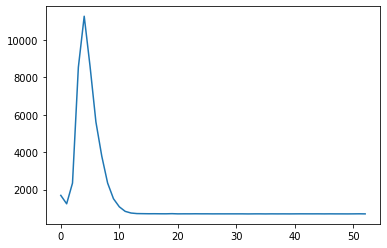

In [37]:
model3.compile(
    optimizer="adam",
    loss="mae",
    metrics=['mae'],
)
history = model3.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=128,
    callbacks=[early_stopping],
    epochs=100,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df['val_loss'].plot()
best_results = history_df['val_loss'].min()
print("Minimum Validation Loss: {:0.4f}".format(best_results))
print("Highest Accuracy: {:0.4%}".format(1-(best_results/df['Item_Outlet_Sales'].mean())))

### Again we are improving, but not by enough to be useful. We need to improve our data. Lets try using GridSearchCV!

In [38]:
from sklearn.model_selection import GridSearchCV

### Lets start by using grid search on our RandomForestRegressor

In [39]:
param_grid = {
    "n_estimators": [x for x in range(100,251,50)],
    "max_features": [1.0,"sqrt","log2"],
    "min_weight_fraction_leaf": [0.0, 0.1, 0.01],
}


grid_search = GridSearchCV( estimator = RandomForestRegressor(),
                            param_grid = param_grid,
                            scoring = "neg_mean_absolute_error",
                            n_jobs = 4,
                            verbose = 2)

In [40]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_features': [1.0, 'sqrt', 'log2'],
                         'min_weight_fraction_leaf': [0.0, 0.1, 0.01],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='neg_mean_absolute_error', verbose=2)

In [41]:
print_stats(grid_search,X_valid,y_valid)

The MAE for this model is 701.75
The accuracy for this model is 66.015313%


In [42]:
grid_search.best_params_

{'max_features': 1.0, 'min_weight_fraction_leaf': 0.01, 'n_estimators': 200}